In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("Eluvio_DS_Challenge.csv")
dataset.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [3]:
len(dataset)

509236

In [4]:
dataset.info() # it looks like nulls donot exist in the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


In [5]:
dataset["author"].value_counts() 

#It looks like the dataset has the (titles) posted by a different authors.

davidreiss666    8897
anutensil        5730
DoremusJessup    5037
maxwellhill      4023
igeldard         4013
                 ... 
jeffreyg            1
imagadan_b          1
Elite-Hawk          1
NicFLAre            1
Zeralot             1
Name: author, Length: 85838, dtype: int64

In [6]:
print(dataset["category"].value_counts()) 
#there is only one category and that is worldnews, so this variable won't help us in analytics

print("\n",dataset["over_18"].value_counts())
#if we build a model with outcome as over_18, there will be a bias and predictions will be False as the count of False data is more.

worldnews    509236
Name: category, dtype: int64

 False    508916
True        320
Name: over_18, dtype: int64


In [8]:
#let's add a new column which represents the number of characters used within each title

dataset["text_length"] = dataset["title"].apply(len)
dataset.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,text_length
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,33
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,32
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,31
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,44
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,47


# Exploratory Data Analysis

In [10]:
import matplotlib.pyplot as plt

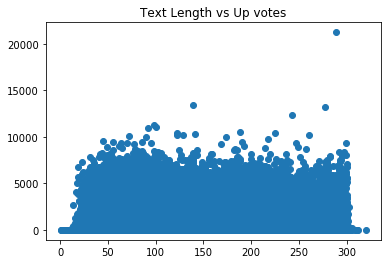

In [16]:
plt.scatter(dataset["text_length"], dataset["up_votes"])
plt.title("Text Length vs Up votes")
plt.show()

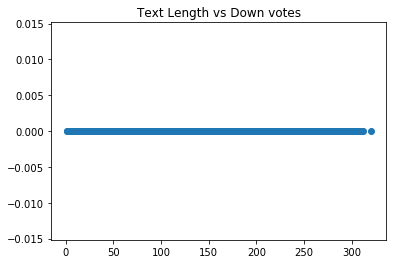

In [17]:
plt.scatter(dataset["text_length"], dataset["down_votes"])
plt.title("Text Length vs Down votes")
plt.show()

#Based on the observattions, there are no downvotes for the titles. 
#So it doesn't make anysense in using this as predictor asit will not effect the outcome variable

**So the only variable that is dependent on title is up_votes.** 

# NLP task

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [28]:
X = dataset["title"] #predictor variable
y = dataset["up_votes"] #outcome variable

In [29]:
print(X.head())

0                  Scores killed in Pakistan clashes
1                   Japan resumes refuelling mission
2                    US presses Egypt on Gaza border
3       Jump-start economy: Give health care to all 
4    Council of Europe bashes EU&UN terror blacklist
Name: title, dtype: object


**The CountVectorizer converts the text to tokens and performs feature extraction (vectorization)**

In [30]:
#creating an object for CountVectorizer
cv = CountVectorizer()

#transforming the data into tokens
X = cv.fit_transform(X)

In [33]:
type(X) #words are parsed and converted to tokents, and the matriz has been created

scipy.sparse.csr.csr_matrix

**Train test split**

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=101)